In [64]:
import qiskit
import qiskit.quantum_info
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_aer import AerSimulator
import qiskit_ibm_runtime
from qiskit_ibm_runtime import Options, Session, SamplerV2 as Sampler
from qiskit_aer.noise import NoiseModel, depolarizing_error
import numpy as np
from qiskit_aer.primitives import Sampler as AerSampler
import matplotlib as plt

In [ ]:
backend = AerSimulator()
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)

In [44]:
def gen_chsh(x, y, num_qubits=2):

    base_qc = qiskit.QuantumCircuit(num_qubits, 2)

    base_qc.h(0)
    base_qc.cx(0, num_qubits - 1)

    if x == 1:
        base_qc.h(0)

    if y == 0:
        base_qc.ry(-np.pi/4, num_qubits - 1)
    elif y == 1:
        base_qc.ry(np.pi/4, num_qubits - 1)   

    base_qc.measure(0, 0)
    base_qc.measure(num_qubits-1, 1)
    #measure_all() #([0, 1], [0, 1])

    return base_qc

In [57]:
circuits = []
input_pairs = []
for x_in in [0, 1]:
    for y_in in [0, 1]:
        input_pairs.append((x_in, y_in))
        circuits.append(gen_chsh(x_in, y_in, 6))

In [60]:
noise_model = NoiseModel()
cx_depolarizing_prob = 0.02
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(cx_depolarizing_prob, 2), ["cx"]
)

### Work in Progress Below

In [ ]:
isa_qc_chsh = pm.run(circuits)
SHOTS=1000

sampler_chsh = AerSampler(backend_options=dict(noise_model=noise_model))
# sampler_chsh = Sampler(
#     mode=backend,
#     options=dict(backend_options=dict(noise_model=noise_model))
# )
job_chsh = sampler_chsh.run(isa_qc_chsh, shots=SHOTS)
results_chsh = job_chsh.result()

print(results_chsh)
counts_list = [results_chsh[i].data.c.get_counts() for i in range(len(circuits))]

print("\n--- Simulation Results (Counts) ---")
for i, (x, y) in enumerate(input_pairs):
    print(f"Inputs (x={x}, y={y}):")
    sorted_counts = dict(sorted(counts_list[i].items()))
    print(f"  Outcomes (ba): {sorted_counts}")

print("\nPlotting results...")
display(qiskit.visualization.plot_histogram(counts_list,
                       legend=[f'(x={x}, y={y})' for x, y in input_pairs],
                       title='CHSH Game Outcomes (ba format)'))

SamplerResult(quasi_dists=[{2: 0.067, 0: 0.4, 3: 0.443, 1: 0.09}, {1: 0.064, 2: 0.092, 0: 0.442, 3: 0.402}, {1: 0.073, 2: 0.09, 0: 0.406, 3: 0.431}, {3: 0.076, 0: 0.078, 2: 0.416, 1: 0.43}], metadata=[{'shots': 1000, 'simulator_metadata': {'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 10, 'parallel_shots': 1, 'sample_measure_time': 0.00012225, 'noise': 'superop', 'batched_shots_optimization': False, 'remapped_qubits': True, 'active_input_qubits': [0, 5], 'device': 'CPU', 'time_taken': 0.00044025, 'measure_sampling': True, 'num_clbits': 2, 'max_memory_mb': 24576, 'input_qubit_map': [[5, 1], [0, 0]], 'num_qubits': 2, 'method': 'density_matrix', 'required_memory_mb': 1, 'fusion': {'enabled': True, 'threshold': 7, 'applied': False, 'max_fused_qubits': 2}}}, {'shots': 1000, 'simulator_metadata': {'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 10, 'parallel_shots': 1, 'sample_measure_time': 8.9292e-05, 'noise': 'superop', 'ba

TypeError: 'SamplerResult' object is not subscriptable

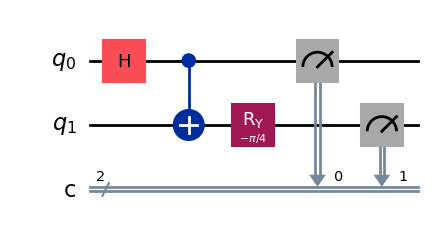

In [ ]:
qc = gen_chsh(0, 0, 2)

qc.draw('mpl')

In [3]:
def cx_chain(n_qubits):
    qc = qiskit.QuantumCircuit(n_qubits)

    half = int(n_qubits / 2)

    for i in range(half - 1):
        qc.cx(i, i + 1)
        qc.cx(i + 1, i)

        qc.cx(n_qubits - (i + 1), n_qubits - (i + 2))
        qc.cx(n_qubits - (i + 2), n_qubits - (i + 1))

    qc.cx(int(n_qubits/2)-1, int(n_qubits/2))

    for i in reversed(range(half - 1)):
        qc.cx(i + 1, i)
        qc.cx(i, i + 1)

        qc.cx(n_qubits - (i + 2), n_qubits - (i + 1))
        qc.cx(n_qubits - (i + 1), n_qubits - (i + 2))

    return qc

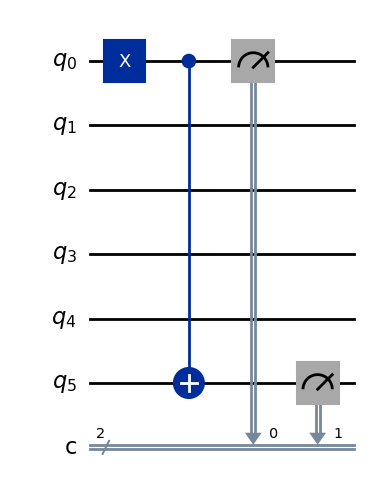

In [ ]:
custom_cnot = cx_chain(6).to_gate(label="CNOT")
qc = qiskit.QuantumCircuit(6, 2)

#qc.h(0)
qc.x(0)
#qc.append(custom_cnot, [0, 1, 2, 3, 4, 5])
qc.cx(0, 5) # used default since has lower depth after transplation
#qc.ry(-np.pi/4, 1)
qc.measure(0, 0)
qc.measure(5, 1)

qc.draw("mpl")

In [ ]:
print("Preparing circuits for the simulator...")
isa_qc_chsh = pm.run(qc)

sampler = Sampler(mode=backend)
counts = sampler.run([isa_qc_chsh], shots = 1000).result()[0].data .c.get_counts()


Preparing circuits for the simulator...


In [32]:
service = qiskit_ibm_runtime.QiskitRuntimeService()

In [33]:
print("The circuit depth is:", qc.depth())
qc_transpiled = qiskit.transpile(qc, service.backend('ibm_brisbane') , optimization_level=3)
print("The TRANSPILED circuit depth is:", qc_transpiled.depth())

The circuit depth is: 3
The TRANSPILED circuit depth is: 8
